# Mechanical failure 

## Resources

### Survival Analysis Resources

* [Survival Analysis - KDNuggets Primer](https://www.kdnuggets.com/2020/07/complete-guide-survival-analysis-python-part1.html)
* [Python package - pysurvival](https://square.github.io/pysurvival/tutorials/maintenance.html)

### Relevant Data Sets

* [Kaggle ConocoPhillipsDatathon Soln](https://github.com/DeepBhat/ConocoPhillipsDatathon)
* [Kaggle Competition](https://www.kaggle.com/c/predictive-maintenance1/overview)

### TurboFan Data Set

* [Prognostic Data Repository](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository)
* [Data set source](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

To download the data set from it's source:

```bash
wget -O ../data/CMAPSSData.zip -nc https://ti.arc.nasa.gov/c/6/ 
```                                

This notebook is available on GitHub: https://github.com/ajrichards/AFPM-Talk

## Description

An engine degradation simulation was carried out using [C-MAPSS](https://software.nasa.gov/software/LEW-18315-2).

> The goal of these experiments is to model damage propagation within the modules of aircraft gas turbine engines

There is a single table of sensor observations over time. It is how the data would often appear in many manufacturing and production scenarios.  The goal of this exercise is to predict the Remaining Useful Life (RUL).  The RUL estimates are in units
of time (e.g., hours or cycles).  Predicting RUL is a task that falls into the category of *predictive maintenance*.  Here are some of the reasons why this is important to industry today.

* Improve workplace safety 
* Optimize maintenance costs 
* Increased productivity by minimizing downtime and reactive maintenance

### From the perspective of a story...

* **Characters** → Plant managers, safety engineers, other stakeholders 
* **Settings** → The current state can always be improved---**Cost savings**
* **Plot** → Improved predictive maintenance will result in less down time, increased safety, and a more effective use of staff and equipment.
* **Conflict**  → Do we have the right data? Do we have the right talent? Do we have a plan in place to use leverage model results?
* **Plan**  → Use Python and Machine learning to train a model that will predict whether or not a machine is in a specific RUL window.


First let's make our imports and load in the data.

In [1]:
import os
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2
from mflib import *

In [2]:
# load data
data_dir = os.path.join("..", "data")
all_data = load_data(data_dir)
df = all_data['FD_001']['df_train'].copy()

... loading data


Notes on features:

In a typical use case for predictive maintence you will have a time-series data set.  Features in this family of problems tend to fall into the following categories:

- IoT features - internet of things which is generally a sensor or relayed machine output
- Company features - which team, plant, facility, individuals responsible for maintence
- Machine feature - unit id, manufacturer, year built
- Exogenous features - like weather data

## A look at the data

These data are actually 4 different data sets each with train and test data contained therein.  Let's use one of the data sets in this example.  See the `readme.txt` file and pdf that accompany the data for more description.   Each data set contains multiple units and  each unit starts at a certain degradation point and the measurement data ends closely before the unit taken offline. 

We assume that the last measurement time that is available for a unit is RUL=0.

In [10]:
all_data.keys()
df = all_data['FD_001']['df_train'].copy()
df.head(5).iloc[:,:10]

,unit_nr,time,os_1,os_2,os_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62


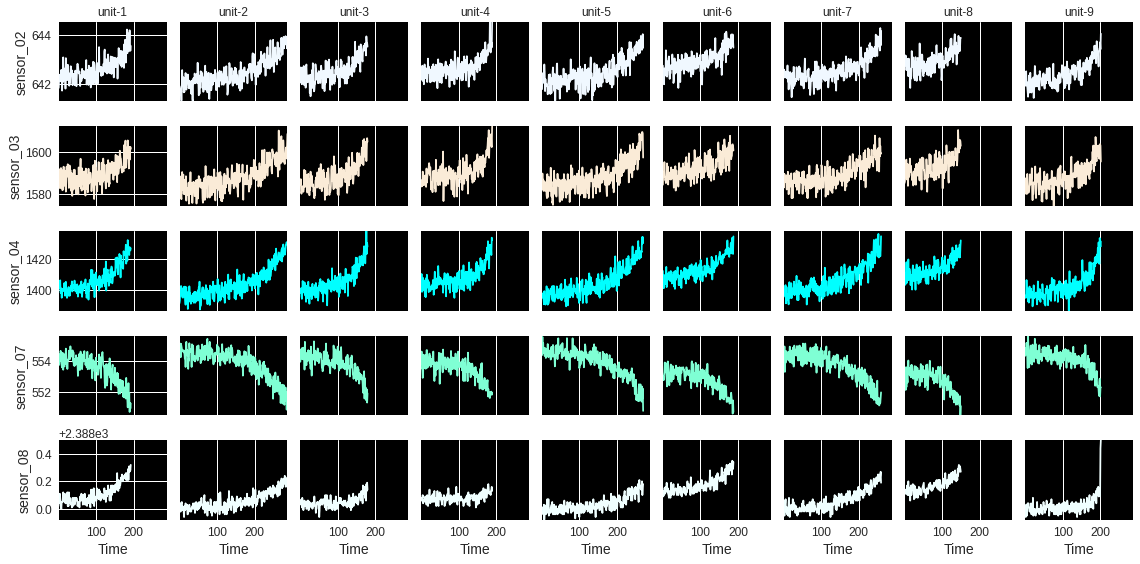

In [4]:
# EDA
unit_subset = df['unit_nr'].unique()[:9]
features = ['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_08']
plt = plot_subset(df, unit_subset, features) 

## Create a column for RUL and a needs maintenance target

For each unit there is some amount of time it ran before it was taken offline, call it `total_runtime`.  For each time stamp we can calculate RUL by subtracting the it from the `total_runtime`.

In [5]:
# make target
df = make_target(df, before_failure=10)

... making a needs maintenance target
...... orig data shape 20631 x 34


## Clean the data and prepare it for model input

In [6]:
# munge data
numeric_features = ['os_1', 'os_2', 'os_3'] + ['sensor_' + str(i).zfill(2) for i in range(2, 22)]
categorical_features = ['unit_nr']
X, y, numeric_features = munge_data(df, numeric_features, categorical_features)

... munging data
...... # columns dropped due to excessive NaNs: ['sensor_22', 'sensor_25', 'sensor_26', 'sensor_23', 'sensor_24']
...... columns dropped based on variance: ['sensor_16', 'sensor_18', 'sensor_10', 'os_3', 'sensor_05', 'os_2', 'sensor_19']
...... # of columns explicitly not used: 17
...... feature matrix shape: 20631 x 17


## Model Training

In [7]:
print("... model training")

# define a preprocessor and perform a train-test split
preprocessor = get_preprocessor(numeric_features, categorical_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
target_names = ["no_maintenance", "yes_maintenance"]
print("...... train", sorted(Counter(y_train).items()))
print("...... test", sorted(Counter(y_test).items()))
print("...... target names", target_names)

# define the model pipeline
time_start = time.time()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('sgd', SGDClassifier(class_weight='balanced'))])

# train the model by optimizing over a specified parameter grid
param_grid = {'sgd__penalty': ['l2', 'l1', 'elasticnet'],
              'sgd__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

# model results
print("... model results")
print("...... train time", time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start)))
print("...... best parameters: ", grid.best_params_)
print("...... model score: %.3f" % balanced_accuracy_score(y_test, y_pred))
print('done')

... model training
...... train [(0, 15704), (1, 800)]
...... test [(0, 3927), (1, 200)]
...... target names ['no_maintenance', 'yes_maintenance']
... model results
...... train time 00:00:04
...... best parameters:  {'sgd__loss': 'squared_hinge', 'sgd__penalty': 'elasticnet'}
...... model score: 0.950
done


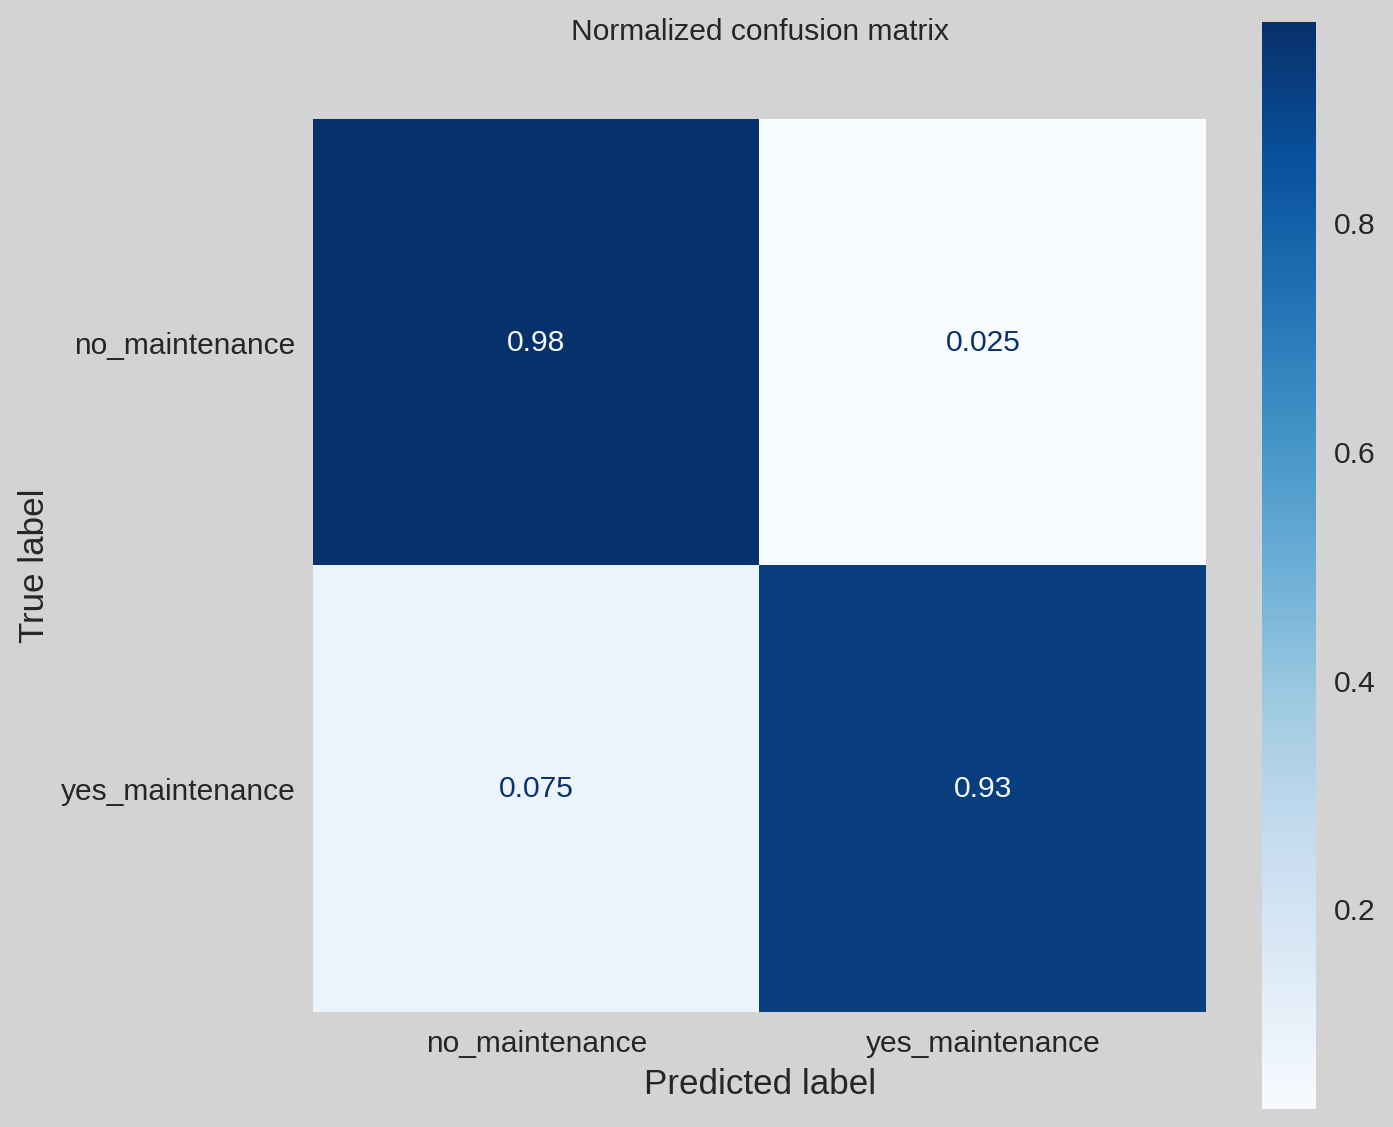

In [11]:
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(8,8),dpi=180, facecolor='lightgrey')
ax = fig.add_subplot(111)

# Plot normalized confusion matrix
title = "Normalized confusion matrix"

disp = plot_confusion_matrix(grid, X_test, y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize='true',ax=ax)
ax.grid(False)
ax.set_title(title+"\n\n");